# Experiment Notebook

* A/B Testing
* Multi-variants Testing

# Math behind A/B Test

## Binomial approximation to Normal

* The distribution of control and test groups are in __Binomial__ distribution because the data is a series of Bernoulli trials.

$$E(X) = p$$

$$VAR(X) = p(1-p)$$

* We can approximate __binomail__ distribution using __normal__ distribution based on the central limit theorm

$$ \hat{p} \sim Normal(\mu = p, \sigma = \frac{\sqrt{p(1-p)}}{\sqrt{n}})$$ 

* The pooled standard error is used for the normal distribution approximation:

$$ \sigma = \sqrt{VAR(\hat{d})} = s_p \sqrt{\frac{1}{n_A} + \frac{1}{n_B}} = \sqrt{\hat{p}_p(1 - \hat{p}_p)(\frac{1}{n_A} + \frac{1}{n_B})}$$

Where $$\hat{p}_p = \frac{p_An_A + p_Bn_B}{n_A + n_B}$$


## Define Hypothesis


__The null hypothesis__: there is no difference between treatment and control group in user conversion with the treatment

$$H_0: \hat{d}_0 = 0 $$

$$ \hat{d}_0 \sim Normal(0, SE_{pool})$$

__The alternative hypothesis__: there are difference between treatment and control groups in user conversion with the treatment

$$H_A: \hat{d}_A = p_B - p_A$$

$$\hat{d}_A \sim Normal(d, SE_{pool})$$

The difference between mean of control and test distribution is Cohen's d (effect size):

$$\hat{d} = \hat{p}_B - \hat{p}_A$$


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import scipy.stats as scs

# local module
from utils import plot, stats

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pre-Experiment 

## Determine the Minimum Sample Size

Input:

* baseline conversion rate
* minimum detectable effectsize (**absolute**)
* desired statistical Power
* significant level

In [39]:
# Example
bcr = 0.10
mde = 0.03
power = 0.8
sig = 0.10
min_sample_size = stats.min_sample_size(bcr=bcr, mde=mde, power=power, sig_level=sig)
print ("The minimun sample size needed for the test is: {:.0f}".format(min_sample_size))

The minimun sample size needed for the test is: 1398


# Post Experiment

## Define Parameters

In [54]:
# Example
bcr = 0.05  # baseline conversion rate
d_hat = 0.02  # difference between the groups

# Sample Size
# A is control ; B is test
N_A = 2500
N_B = 2500

In [55]:
p_A, p_B = bcr, bcr + d_hat
print("Control Group conversion rate: {:}, Test Group conversion rate: {:}".format(p_A, p_B))

Control Group conversion rate: 0.05, Test Group conversion rate: 0.07


In [56]:
pval = stats.p_val_Z(N_A, N_B, p_A, p_B, two_tailed=False)
print("P value of the A/B Testing is: {}".format(pval))

P value of the A/B Testing is: 0.0014407725480533953


# Distribution Plot 

Plot Power

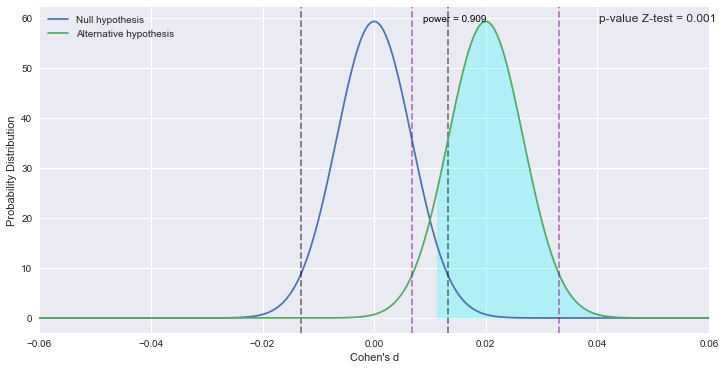

In [65]:
plot.abplot(N_B, N_A, bcr, d_hat, plot_power=True, add_p_value=True)

Plot Alpha

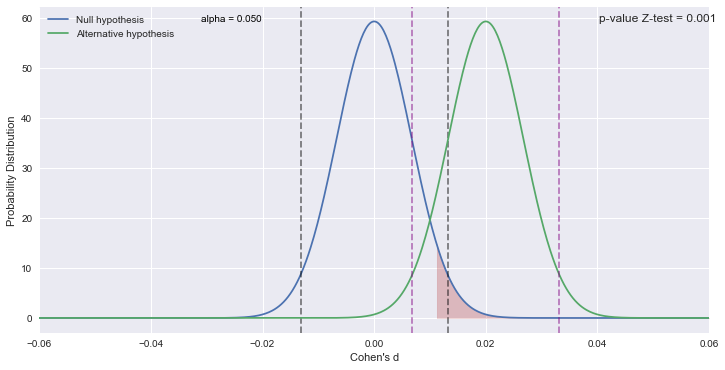

In [66]:
plot.abplot(N_B, N_A, bcr, d_hat, plot_alpha=True, add_p_value=True)

Plot Beta

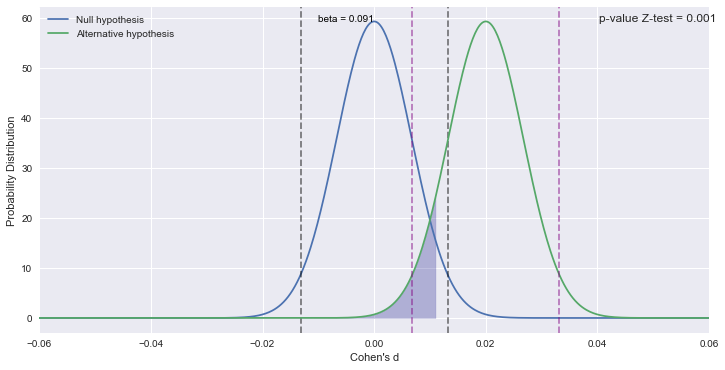

In [67]:
plot.abplot(N_B, N_A, bcr, d_hat, plot_beta=True, add_p_value=True)

## Conclusion

We cannot reject the null hypothesis that the treatment did not increase user conversion rate with confidence level of 1 - p_val% = (1 - 0.001) = 99.9% and it is statistically significant

# Regression and Covariates

Instead of using statistical test, we can perform analysis of A/B test and experiment using regression, which is argurably a better and more flexible approaches. In addition to measure whether there are statistical significant difference between the control and the treatment group, we can also regress against covariants. This will not only tell us about the effect of covariate (explain some of the residuals) but also isolate covariant inbalance between the control and treatment  

For example:

$$ Y = \beta_1X_1 + \beta_2X_2 + e_i$$


Where 
* $Y$: converted (T/F)
* $X_1$: treated (T/F)
* $X_2$: convariant (T/F)

In [30]:
import pandas as pd
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.display import HTML

In [19]:
ab_test = pd.read_csv('./data/ab_test_example.csv') 
ab_test.head(5)

,id,variant,convert,user_segment
0,58,Variant 1,0.0,seg1
1,93,Control,0.0,seg1
2,126,Control,0.0,seg1
3,223,Control,0.0,seg1
4,275,Variant 1,1.0,seg1


In [25]:
ab_test['treated'] = ab_test['variant'].apply(lambda x: 1.0 if x == 'Variant 1' else 0.0)
ab_test['is_seg1'] = ab_test['user_segment'].apply(lambda x: 1.0 if x == 'seg1' else 0.0)
ab_test.head(5)

,id,variant,convert,user_segment,treated,is_seg1
0,58,Variant 1,0.0,seg1,1.0,1.0
1,93,Control,0.0,seg1,0.0,1.0
2,126,Control,0.0,seg1,0.0,1.0
3,223,Control,0.0,seg1,0.0,1.0
4,275,Variant 1,1.0,seg1,1.0,1.0


__model1__:  Regression only on *Treated* 

In [27]:
X = ab_test['treated']
Y = ab_test['convert']

# Regression model
m1 = sm.OLS(Y, X).fit()

# model summary
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                convert   R-squared (uncentered):                   0.076
Model:                            OLS   Adj. R-squared (uncentered):              0.076
Method:                 Least Squares   F-statistic:                              5621.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):                        0.00
Time:                        23:09:27   Log-Likelihood:                          1008.1
No. Observations:               68434   AIC:                                     -2014.
Df Residuals:                   68433   BIC:                                     -2005.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
treated        0.0759      0.001     74.970      0.000       0.074       0.078
==============================================================================
Omnibus:                    48532.531   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           482432.746
Skew:                           3.557   Prob(JB):                         0.00
Kurtosis:                      13.889   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__model1__:  Regression on *Treated* and *is_seg1*

In [28]:
X = ab_test.loc[:, ['treated', 'is_seg1']]
Y = ab_test["convert"]

# Note the difference in argument order
m2 = sm.OLS(Y, X).fit()
#predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                convert   R-squared (uncentered):                   0.076
Model:                            OLS   Adj. R-squared (uncentered):              0.076
Method:                 Least Squares   F-statistic:                              2813.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):                        0.00
Time:                        23:10:43   Log-Likelihood:                          1010.6
No. Observations:               68434   AIC:                                     -2017.
Df Residuals:                   68432   BIC:                                     -1999.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
treated        0.0798      0.002     39.355      0.000       0.076       0.084
is_seg1       -0.0042      0.002     -2.217      0.027      -0.008      -0.000
==============================================================================
Omnibus:                    48422.584   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           479009.788
Skew:                           3.548   Prob(JB):                         0.00
Kurtosis:                      13.846   Cond. No.                         3.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Use stargazer to compare models

In [31]:
stargazer = Stargazer([m1, m2])
stargazer.title("A/B Test Regression Models")
HTML(stargazer.render_html())

The treatment group has 8% positive conversion lift to the control group. The fact a user belong to segment 1, has -0.4% impact to the conversion. Both coefficent is statistically significant with P-Value less than 0.05 